# Imports and Constants: 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
import scienceplots
from cycler import cycler
import numpy as np
from pathos.multiprocessing import ProcessingPool as Pool
from itertools import product
from tqdm import trange, tqdm
import os
import itertools
plt.style.use(['science','ieee','notebook'])
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#9A0EEA'])
plt.rcParams.update({'font.serif': 'serif', 'font.family' : 'DeJavu Serif'})
plt.rcParams.update({
        'font.size': 21,
        'axes.labelsize': 21,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16
    })

# Constants:
G = 6.67e-11
c = 3e8
hbar = 1.05e-34
solarMass = 1.9891e30
T_obs = 604800
frequencies = np.logspace(0,5,100000)
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#9A0EEA']

# Graphing Code: 

In [2]:
def plot_contourIntSNR(x_vals, y_vals, Z_list_vector, Z_list_scalar, M_max, labelsVector, labelsScalar):
    
    # Create a contour graph for different parameter values of boson cloud rest energy and black hole mass for different interferometer configurations
    
    # Plot contour lines where the SNR=8 for each interferometer configuration
    fig, ax1 = plt.subplots(figsize=(10, 8))
    contour_levels = []
    scalar_levels = []
    
    for i, Z in enumerate(Z_list_scalar):
        
        # Create contour lines of SNR=8 for the different interferometers
        cp = ax1.contour(x_vals, y_vals, Z, levels=[8], colors=colors[i], zorder=0, alpha=0.65)
        
        # Set dashed linestyle for each contour line
        for line in cp.collections:
            line.set_linestyle('--')
        
        # Collect for legend
        scalar_levels.append(cp.collections[0])

    for i, Z in enumerate(Z_list_vector):
        
        # Create contour lines of SNR=8 for the different interferometers
        cp = ax1.contour(x_vals, y_vals, Z, levels=[8], colors=colors[i], zorder=0)
        
        # Collect for legend
        contour_levels.append(cp.collections[0])
    
    # Formatting primary x and y axes
    ax1.set_xlabel("Boson rest energy (eV)")
    ax1.set_ylabel(r"Black hole mass ($M_{\odot}$)", labelpad=-8)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.xaxis.tick_bottom()
    
    # Define the region for shading (no superradiance) and fill it with light gray
    x_fill_vals = x_vals[:, 0]
    y_min_array = np.full_like(x_fill_vals, M_max)
    y_max_value = np.max(y_vals)
    ax1.fill_between(x_fill_vals, y_min_array, y_max_value, color='lightgray', zorder=0)
    
    # Create first legend for vector boson contour SNRs
    if contour_levels:
        vector_legend = [plt.Line2D([0], [0], color=color, lw=2) for color in colors[:len(contour_levels)]]
        #vector_legend.append(Patch(color='lightgray', label='No superradiance'))  # Add gray box for filled region
        legend1 = ax1.legend(vector_legend, labelsVector[:len(vector_legend)], loc='lower left', # + ['No superradiance']
                   frameon=True, framealpha=0.75, facecolor='white', ncol=2, title="Vector boson clouds")
        ax1.add_artist(legend1)  # Add the first legend manually to retain it
        
    # Create the second legend for scalar boson contour SNRs
    if scalar_levels:
        scalar_legend = [plt.Line2D([0], [0], color=color, lw=2, linestyle='--', alpha=0.65) for color in colors[:len(scalar_levels)]]
        ax1.legend(scalar_legend, labelsScalar[:len(scalar_legend)], loc='upper right',
                   frameon=True, framealpha=1, facecolor='white', ncol=2, title="Scalar boson clouds")
        
    # Conversion function to create labels for secondary y axis based on label value of primary y axis
    def convert_to_frequency(y):
        return (64500 * (6.67e-11) * y * (1.9891e30) * (1.6e-19)) / (((3e8)**3) * (1.05e-34))
    
    # Function that makes secondary y labels be scientific notation
    def format_scientific_notation(value, precision=2):
        formatted = f"{value:.{precision}e}"
        base, exponent = formatted.split('e')
        exponent = int(exponent)
        return f"$10^{exponent}$"
    
    # Create top x-axis for emission frequency
    ax2 = ax1.secondary_xaxis('top', functions=(convert_to_frequency, lambda x: x))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_scientific_notation(x, 2)))
    ax2.set_xlabel('Emission frequency (Hz)', labelpad=10)
    
    # Set all other ticks to point outwards
    ax1.tick_params(direction='out', which='both')
    ax2.tick_params(direction='out', which='both')
    
    # Remove tick marks on the right y-axis
    ax1.tick_params(axis='y', which='both', right=False)
    
    # No grid
    plt.grid(False)
    plt.gca().xaxis.grid(False, which='both')
    plt.gca().yaxis.grid(False, which='both')
    plt.ylim(1e-1,1e1)
    plt.xlim(1e-12,1e-10)
    
    # Show (and optionally save) graph:
    # plt.savefig('Boson Cloud 8-SNR graph.pdf',format='pdf', dpi=300)
    
    plt.show()
    
    return

# Simulation Code:

In [3]:
def strainVector(M, u, alpha, distance):
    
    mass = M*solarMass
    finalmass = 0.9*mass
    alphaf = (G*finalmass*u)/((c**3)*hbar) * (1.6e-19)
    chif = (4*alphaf)/(4*((alphaf)**2) + 1)
    
    hfv = (4e-24) * (M*0.1) * ((alpha/0.1)**5) * (1/distance) * ((0.7 - chif)/(0.1))
    
    
    return hfv
def strainScalar(M, u, alpha, distance):
    
    mass = M*solarMass
    finalmass = 0.9*mass
    alphaf = (G*finalmass*u)/((c**3)*hbar) * (1.6e-19)
    chif = (4*alphaf)/(4*((alphaf)**2) + 1)
    
    hfs = (8e-28) * (M*0.1) * ((alpha/0.1)**7) * (1/distance) * ((0.7 - chif)/(0.1))
    
    return hfs

In [4]:
def compute_vector_task(S, M, u, dist, Faverage):
    
    mass = M*solarMass
    alpha = (G*mass*u)/((c**3)*hbar) * (1.6e-19)
    f_0 = 645*(10/M)*(alpha/0.1)
    antenna_pattern = np.interp(f_0, frequencies, Faverage)
    vectorSNR = np.nan
    
    if alpha<0.204:
        # Calculate ASD and PSD at specific boson cloud emission frequency:
        ASD = np.interp(f_0, frequencies, S)
        PSD = (ASD**2)
        
        # Vector Boson Cloud strain and SNR calculation:
        T_gw_Vector = 86400*(M/10)*((0.1/alpha)**11)*(1/0.7)
        time_Vector = np.min([T_obs, T_gw_Vector])
        hfv = strainVector(M, u, alpha, dist)
        vectorSNR = np.sqrt(np.abs((((np.abs(hfv*antenna_pattern))**2)*time_Vector)/PSD))
    
    return vectorSNR

def compute_scalar_task(S, M, u, dist, Faverage):
    
    mass = M*solarMass
    alpha = (G*mass*u)/((c**3)*hbar) * (1.6e-19)
    f_0 = 645*(10/M)*(alpha/0.1)
    antenna_pattern = np.interp(f_0, frequencies, Faverage)
    scalarSNR = np.nan
    
    if alpha<0.204:
        # Calculate ASD and PSD at specific boson cloud emission frequency:
        ASD = np.interp(f_0, frequencies, S)
        PSD = (ASD**2)
        
        # Scalar Boson Cloud strain and SNR calculation:
        T_gw_Scalar = (6.4e4)*31536000*(M/10)*((0.1/alpha)**15)*(1/0.7)
        time_Scalar = np.min([T_obs, T_gw_Scalar])
        hfs = strainScalar(M, u, alpha, dist)
        scalarSNR = np.sqrt(np.abs((((np.abs(hfs*antenna_pattern))**2)*time_Scalar)/PSD))
    
    return scalarSNR

In [5]:
def vectorSNR(S, M, u, dist, Faverage):
    
    # Create a 2D array of all possible combinations of the two parameter values
    input_combinations = list(product(M, u))
    num_items = len(input_combinations)
    
    # Number of cores to process (leaving one available)
    num_cores = os.cpu_count() - 1
    
    def fun_wrapper(args):
        return compute_vector_task(S, args[0], args[1], dist, Faverage)
    
    with Pool(num_cores) as pool:
        vectorSNR = list(tqdm(pool.imap(fun_wrapper, input_combinations), total=num_items))
        
    N1 = len(M)
    N2 = len(u)
    
    axisY, axisX = np.meshgrid(M, u)
    Z = np.reshape(np.array(vectorSNR), (N1, N2))
    
    return axisX, axisY, Z

def scalarSNR(S, M, u, dist, Faverage):
    
    # Create a 2D array of all possible combinations of the two parameter values
    input_combinations = list(product(M, u))
    num_items = len(input_combinations)
    
    # Number of cores to process (leaving one available)
    num_cores = os.cpu_count() - 1
    
    def fun_wrapper(args):
        return compute_scalar_task(S, args[0], args[1], dist, Faverage)
    
    
    with Pool(num_cores) as pool:
        scalarSNR = list(tqdm(pool.imap(fun_wrapper, input_combinations), total=num_items))
        
    N1 = len(M)
    N2 = len(u)
    
    axisY, axisX = np.meshgrid(M, u)
    Z = np.reshape(np.array(scalarSNR), (N1, N2))
    
    return axisX, axisY, Z

# Initialize Inputs and Run Simulation:

In [6]:
# Set simulation parameter values:
M = np.logspace(-1, 1, 350) #black hole solar masses
u = np.logspace(-12,-10, 350) #boson individual rest energies
dist = 0.03 # distance of boson cloud in Mpc- 0.03 is our galaxy distance
srm_phi_vector = [23,32,35] #SRM detuning angles to use for GEO's ASD arrays for vector bosons (excluding 0 (tuned) - always calculated)
srm_phi_scalar = [7] #SRM detuning angles to use for GEO's ASD arrays for scalar bosons (excluding 0 (tuned) - always calculated)

# Load in the ASD arrays for aLIGO and different detuning angles of GEO600 for vector and scalar specific detunings
ASD_list_vector= []
ASD_list_scalar= []
with np.load('ASD_50W_100000_05.npz') as data:
    aLIGOasd = data['aLIGO']
    GEO600asd = data['GEO600']
    for phi in srm_phi_vector:
        asd_array = data[f'GEO600_{phi}']
        ASD_list_vector.append(asd_array)
    for phi in srm_phi_scalar:
        asd_array = data[f'GEO600_{phi}']
        ASD_list_scalar.append(asd_array)

# Load in the antenna pattern arrays for GEO600 and LIGO:
with np.load('GEO_F_rms_100000_05.npz') as data:
        Faverage = data['F_rms']       
with np.load('LIGO_F_rms_100000_05.npz') as data:
        FaverageLIGO = data['F_rms']

# Call the contour function for aLIGO and GEO600 plus all detunings inputed initially
X, Y, vectorLIGOSNR = vectorSNR(aLIGOasd, M, u, dist, FaverageLIGO)
X, Y, scalarLIGOSNR = scalarSNR(aLIGOasd, M, u, dist, FaverageLIGO)
X, Y, vectorGEOSNR = vectorSNR(GEO600asd, M, u, dist, Faverage)
X, Y, scalarGEOSNR = scalarSNR(GEO600asd, M, u, dist, Faverage)
SNR_list_vector = [vectorLIGOSNR.T, vectorGEOSNR.T]
SNR_list_scalar = [scalarLIGOSNR.T, scalarGEOSNR.T]
for ASD in ASD_list_vector:
    X, Y, vectorSNR_temp = vectorSNR(ASD, M, u, dist, Faverage)
    SNR_list_vector.append(vectorSNR_temp.T)
for ASD in ASD_list_scalar:
    X, Y, scalarSNR_temp = scalarSNR(ASD, M, u, dist, Faverage)
    SNR_list_scalar.append(scalarSNR_temp.T)

100%|████████████████████████████████████| 40000/40000 [00:49<00:00, 809.29it/s]


# Plot Simulation:

/var/folders/db/kn1xj4fj23g0d75vjsb3ykk80000gn/T/ipykernel_77106/2736492984.py:16: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cp.collections:
/var/folders/db/kn1xj4fj23g0d75vjsb3ykk80000gn/T/ipykernel_77106/2736492984.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  scalar_levels.append(cp.collections[0])
/var/folders/db/kn1xj4fj23g0d75vjsb3ykk80000gn/T/ipykernel_77106/2736492984.py:28: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_levels.append(cp.collections[0])


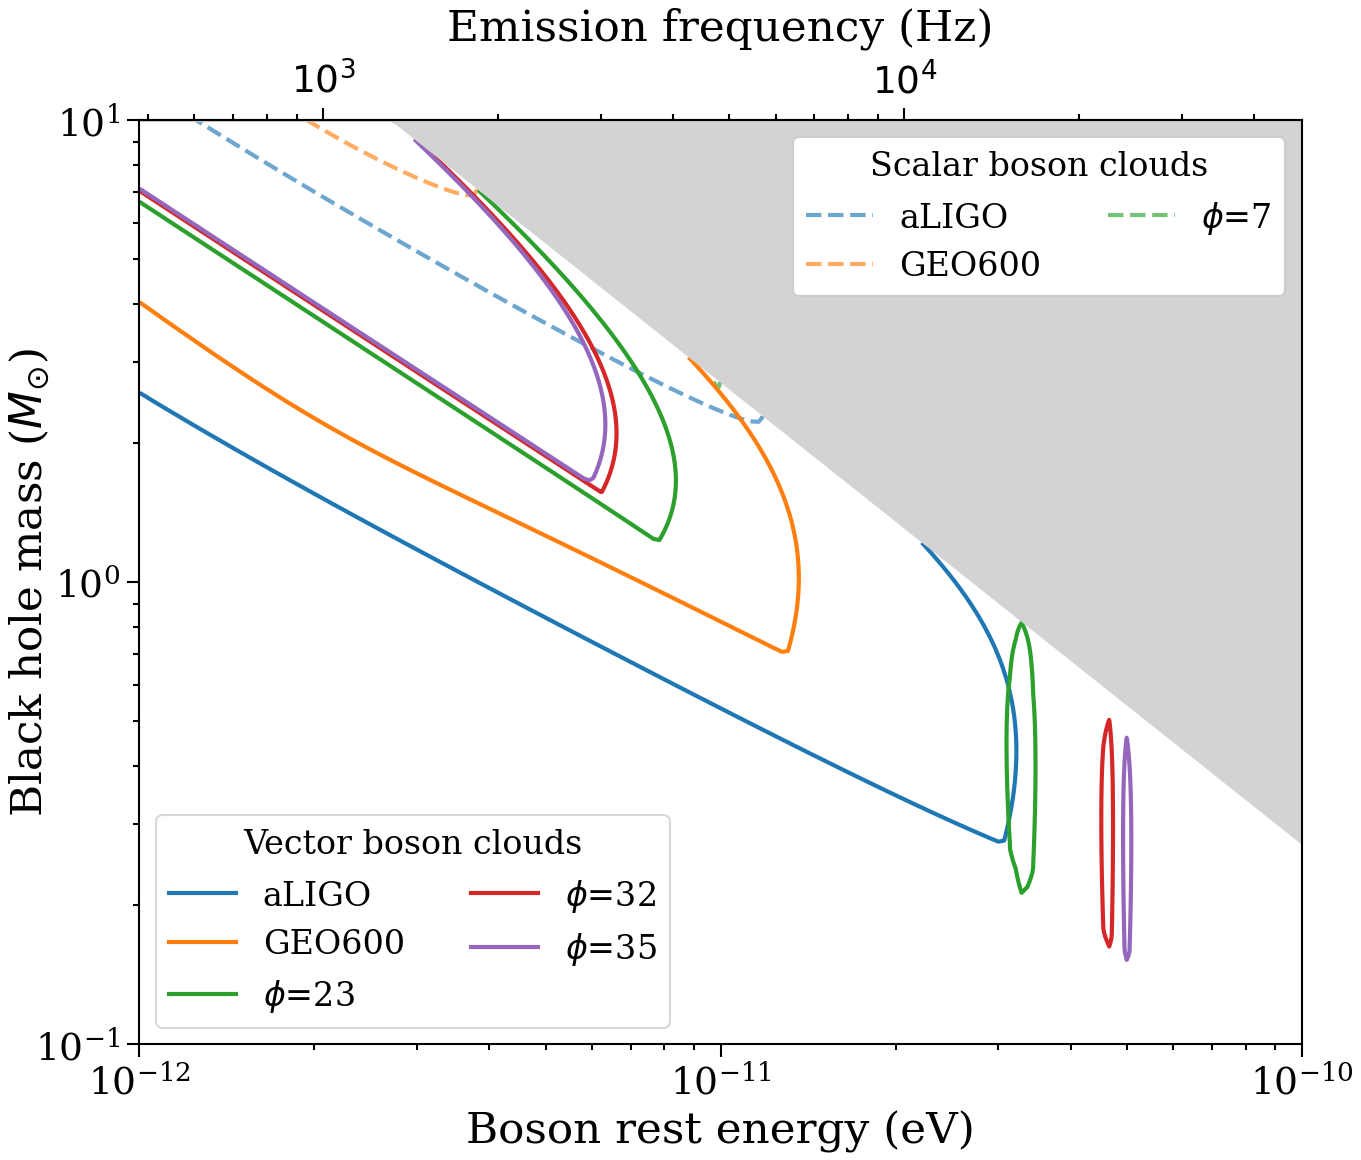

In [9]:
# Create labels to use in graph:
labelsVector = ['aLIGO','GEO600']
labelsScalar = ['aLIGO','GEO600']
for phi in srm_phi_vector:
    labelsVector.append(f'$\phi$={phi}')
for phi in srm_phi_scalar:
    labelsScalar.append(f'$\phi$={phi}')

# Calculate no-superradiance cut-off line for graph:
M_max = np.minimum(10, ((0.204*(c**3)*hbar)/(G*u*(1.6e-19)))/(solarMass))   

# Create Graph:
plot_contourIntSNR(X, Y, SNR_list_vector, SNR_list_scalar, M_max, labelsVector, labelsScalar)